## Corriente de electrones en sistemas abiertos de tres puntos cuánticos en configuración lineal

In [2]:
from joblib import delayed, Parallel

from tqdm.auto import tqdm
import numpy as np

import qutip as qt
import matplotlib.pyplot as plt
import scipy
import matplotlib.colors as mcolors

%matplotlib widget

El Hamiltoniano del sistema, en la base $\mathscr{B}=\{\ket{\varnothing}, \ket{L}, \ket{C}, \ket{R}\}$:

$\begin{equation}
    H_{TQD}^{lin}= \begin{pmatrix}
        0 & 0 & 0 & 0 \\ 
        0 & \epsilon_L & -\tau_{12} & 0 \\
        0 & -\tau_{12} & \epsilon_C & -\tau_{23} \\
        0 & 0& -\tau_{23} & \epsilon_R
    \end{pmatrix}
\end{equation}$

In [3]:
# base
E = qt.basis(4, 0)
L = qt.basis(4, 1)
C = qt.basis(4, 2)
R = qt.basis(4, 3)

In [4]:
# parámetros y operadores
gammaL = 0.05
gammaR = 0.05
psi0 = E

cL = qt.Qobj(np.array([(0,1,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0)]))
cR = qt.Qobj(np.array([(0,0,0,1),(0,0,0,0),(0,0,0,0), (0,0,0,0)]))

LL = np.sqrt(gammaL)*cL
LR = np.sqrt(gammaR)*cR

c_ops = [qt.dag(LL),LR]

Establecemos $\epsilon_R=0$, de modo que $\delta_{LR}=\epsilon_L$, $\delta_{RC}=\epsilon_C$. Hacemos $\tau_{LC}=\tau_{CR}=\tau$.

In [5]:
def pixel(deltaLR, deltaRC):
    tau = 0.5
    H = qt.Qobj(np.array([(0,0,0,0),(0,deltaLR,-tau,0), (0,-tau,deltaRC, -tau), (0, 0, -tau, 0)]))
    state = qt.steadystate(H, c_ops)
    pR = (R.overlap(state))
    return pR

In [6]:
# pintamos la corriente normalizada (I=rho_RR) para distintos valores del detuning y de tau
deltaLR = np.linspace(-6, 6, 201)
deltaRC = np.linspace(-6, 6, 201)

pRs = []
deltasLR_mat = []
deltasRC_mat = []

for i in range(len(deltaLR)):
     for j in range(len(deltaRC)):
        deltasRC_mat.append(deltaRC[j])
        deltasLR_mat.append(deltaLR[i])

In [6]:
pbar = tqdm(range(len(deltasLR_mat)), desc='Calculando...')
resultados = Parallel(n_jobs=-1)(delayed(pixel)(deltasLR_mat[i], deltasRC_mat[i]) for i in pbar)
np.save('current_tqd.npy', resultados)

Calculando...:   0%|          | 0/40401 [00:00<?, ?it/s]

In [7]:
from matplotlib.colors import LinearSegmentedColormap


def hex_to_rgba(hex_color):
    """
    Convierte un color en formato hexadecimal a formato RGBA.
    
    Args:
    - hex_color: Color en formato hexadecimal.
    
    Returns:
    - Color en formato RGBA.
    """
    rgb = mcolors.hex2color(hex_color)
    return (*rgb, 1)

def create_custom_cmap(colors, positions):
    """
    Crea un colormap personalizado a partir de una lista de colores y sus posiciones.
    
    Args:
    - colors: Lista de colores en formato hexadecimal.
    - positions: Lista de posiciones normalizadas (entre 0 y 1).
    
    Returns:
    - Colormap personalizado.
    """
    if len(colors) != len(positions):
        raise ValueError("La longitud de 'colors' debe ser igual a la longitud de 'positions'.")
    
    rgba_colors = [hex_to_rgba(color) for color in colors]
    
    cmap_dict = {'red': [], 'green': [], 'blue': []}
    
    for pos, color in zip(positions, rgba_colors):
        for i, channel in enumerate(['red', 'green', 'blue']):
            cmap_dict[channel].append((pos, color[i], color[i]))
    
    return LinearSegmentedColormap('custom_colormap', cmap_dict)

# Definir lista de colores en formato hexadecimal y posiciones
hex_colors = ['w','#C1CFF6','#5F9EA0','#4D8283','#537E83','#DF9595','#E19B9B', '#F17F8A','#F13D70']
positions = [0.0, 0.05, 0.12,0.2,0.28,0.53,0.57,0.72,1]  # Normalizado entre 0 y 1

# Crear el colormap personalizado
custom_cmap = create_custom_cmap(hex_colors, positions)

In [8]:
resultados = np.load('current_tqd.npy')

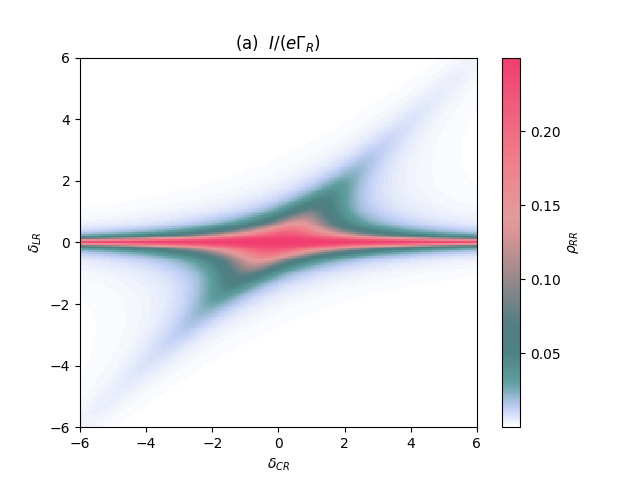

In [12]:
resultados_mat = np.array(resultados).reshape((len(deltaLR), len(deltaRC)))

fig, ax = plt.subplots()
im = ax.imshow(resultados_mat, cmap = custom_cmap, origin='lower', aspect='auto',
                interpolation='none', extent=[min(deltaRC), max(deltaRC), min(deltaLR), max(deltaLR)])
plt.ylabel(r'$\delta_{LR}$')
plt.xlabel(r'$\delta_{CR}$')
plt.title('(a)  'r'$I/(e\Gamma_R)$')
cbar = plt.colorbar(im)
cbar.ax.set_ylabel(r'$\rho_{RR}$')

plt.savefig('./figs/current_tqd.pdf')